In [2]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import matplotlib.mlab as mlab
from matplotlib import cm
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'

plt.rc('text', usetex=False) ## this line is necessary to use the correct fonts 
plt.rc('font', family='serif') # this line is necessary to use the correct font


# This function makes the plots look good 
def plot_prop(f1,ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    # x and y tickers
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.tick_params(direction='out',which='major', length=10,width=1.5,colors='k',labelsize=f1)
    plt.tick_params(direction='out',which='minor',length=5,width=1, color='k')
    
    return;

## The function to generate the stimulus

In [3]:
"""
The function generates the UMRS for the given window size. The parameters are the window size, stimulus 
frequency, time step, and the number of sites of stimulation besides amplitude related paramaters.
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

def UMRS(window_size,Fs,dt,Nsites,Astim,C0,Vth_spike,Vreset):
    
    delV = (Vth_spike - Vreset)
    t_e = 0.5 # width of positive stimulus in ms
    t_ = 0.2# width of gap between positive and negative peaks (in ms)
    t_i = 1.5 # width of negative stimulus in ms
    t_lambda = t_e + t_ + t_i # total duration of a charge-balanced pulse that comprises of the pos and neg peaks (in ms)
    Ae = Astim * delV * C0 / t_e # peak amplitude of the positive (excitatory) stimulus 
    Ai = -Astim * delV * C0 / t_i# peak amplitude of the negative (inhibitory) stimulus 
    
    nt = int(window_size/dt)
    nte = int(t_e/dt) # number of time steps in one positive peak
    nt_ = int(t_/dt) # number of time steps between pos and neg
    nti = int(t_i/dt) # number of time steps in one negative peak
    nt_lambda = nte + nt_ + nti # int(t_lambda/dt) # number of time steps in one charge-balanced pulse
    
    Stimulus = np.zeros([Nsites,nt])
    Fstim = 1.0/(1.0/Fs - 1.0/130) # the mean freq. for generating the exponentially distributed intervals
    
    # preparing the stimulus trains using the exponentially distributed random inter-spike intervals
    for ii in range(Nsites): 
        i_pulse = 0 # index of pulse in the stimulus train (it should be set such that kk begins with at least 0, not negative)
        while (i_pulse < nt-nt_lambda):
            rnd = -np.log(np.random.uniform(0,1))/Fstim # exp_rnd(rnd_generator);
            if (rnd < 1.0/130): continue # int(rnd*1e3/dt) < 1e3/130.0/dt
            i_pulse += int(rnd*1e3/dt)
            if (i_pulse >= nt-nt_lambda-1): break
            for kk in range(i_pulse,i_pulse+nte): Stimulus[ii][kk] = Ae # the positive peak
            for kk in range(i_pulse+nte+nt_,i_pulse+nt_lambda): Stimulus[ii][kk] = Ai # the negative peak

    return Stimulus
    

## Plotting the stimulus pattern and decrease with distance from the electrodes (Fig 2)

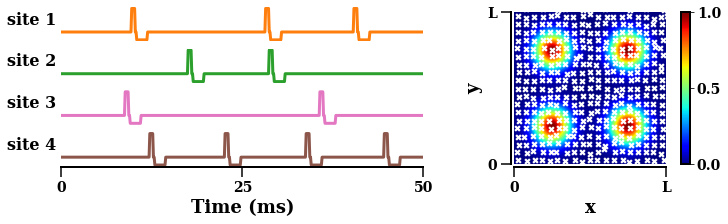

In [5]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

l1=1; f1=14; f2=16; f3=18  # the font sizes 
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10,3)  # the size of the plot in inches 
gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.05, width_ratios=[1.5, 1])  # the gridspace, here I set 2 * 1

gs0 = gs[0].subgridspec(4,1, hspace=0.0)
np.random.seed(300)
window_size = 50; Fs = 50; dt = 0.1; Nsites = 4; Astim = 1; C0 = 3; Vth_spike = 0; Vreset = -67
Stimulus = UMRS(window_size,Fs,dt,Nsites,Astim,C0,Vth_spike,Vreset)

colors = ['C1','C2','C6','C5']
for i in range(4):
    ax = fig.add_subplot(gs0[i])
    plot_prop(f1,ax)
    plt.plot(Stimulus[i],color=colors[i])
    if i < 3: 
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
    if i == 3: 
        ax.set_xticks([0,250,500])
        ax.set_xticklabels([0,25,50])
        ax.set_xlabel('Time (ms)',fontsize=f3)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    
    plt.text(-0.15,0.5,'site %d'%(i+1),fontsize=f2,transform=ax.transAxes)
    plt.xlim(0,500)

##### The map to show spatial spread of stimulus #####
ax = pl.subplot(gs[1])
plot_prop(f1,ax)

np.random.seed(200)
n = 200
dim = 1.0 # in mm

# to visualize stimulus in space
x_ = np.linspace(0,dim,n)
y_ = np.linspace(0,dim,n)
X, Y = np.meshgrid(x_,y_)

sig = 1/3*np.sqrt(0.2/np.pi)*dim # refer to the manuscript
xs_ = np.array([0.25,0.75,0.25,0.75])*dim
ys_ = np.array([0.25,0.25,0.75,0.75])*dim

def func(x,y,xs,ys):
    return np.exp(-((x-xs)**2+(y-ys)**2)/(2*sig**2))

val = np.zeros([n,n])
for i in range(len(xs_)):
    val = val + func(X,Y,xs_[i],ys_[i])
    
# positions of neurons
m=20
N = m*m
xi = np.zeros(N)
yi = np.zeros(N)
hr=dim/(m-1)

for i in range(0,N):
    xi[i] = ((i+0.5)%m)*hr + hr/10.0 * np.sqrt(-2*np.log(np.random.uniform(0,1))) * np.cos(2*np.pi*np.random.uniform(0,1))
    yi[i] = (0.5+int(i/m))*hr + hr/10.0 * np.sqrt(-2*np.log(np.random.uniform(0,1))) * np.sin(2*np.pi*np.random.uniform(0,1))
    

plt.scatter(xi,yi,marker='X',color='white',s=40,linewidths=0.0)
im=plt.imshow(val,origin='lower',cmap='jet',vmin=0,vmax=1,extent=[0,dim,0,dim])
ax.set_xticks([0,1])
ax.set_xticklabels([0,'L'])
ax.set_yticks([0,1])
ax.set_yticklabels([0,'L'])
plt.xlabel('x',fontsize=f3)
plt.ylabel('y',fontsize=f3)
cbar = plt.colorbar(im,fraction=0.1,aspect=60)
cbar.set_ticks([0,0.5,1])
cbar.ax.tick_params(labelsize=f1)

# plt.savefig('UMRS.jpg',dpi=600)
plt.show()